In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
print(os.getcwd())  # Kiểm tra thư mục làm việc hiện tại


e:\GAN Project\SRGAN_Project\Sources


In [4]:
os.chdir("..")  # Quay lại một cấp
# Kiểm tra thư mục hiện tại
print("Current working directory:", os.getcwd())

Current working directory: e:\GAN Project\SRGAN_Project


In [5]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out

class UpscaleBlock(nn.Module):
    def __init__(self):
        super(UpscaleBlock, self).__init__()
        self.conv = nn.Conv2d(64, 256, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.prelu = nn.PReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.prelu(out)
        return out    
    
class Generator(nn.Module):
    def __init__(self, num_res_blocks=16):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.prelu = nn.PReLU()
        self.res_blocks = nn.Sequential(*[ResBlock() for _ in range(num_res_blocks)])
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.upscale1 = UpscaleBlock()
        self.upscale2 = UpscaleBlock()
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        out1 = self.conv1(x)
        out1 = self.prelu(out1)
        out = self.res_blocks(out1)
        out = self.conv2(out)
        out = self.bn(out)
        out += out1
        out = self.upscale1(out)
        out = self.upscale2(out)
        out = self.conv3(out)
        return out
    
generator = Generator().to(device)    

In [6]:
from torchvision import models

class VGGFeatureExtractor(nn.Module):
    def __init__(self, vgg_weights_path):
        super(VGGFeatureExtractor, self).__init__()
        vgg19 = models.vgg19()
        if vgg_weights_path:
            state_dict = torch.load(vgg_weights_path)
            vgg19.load_state_dict(state_dict, strict=False)  


        self.features = nn.Sequential(*list(vgg19.features.children())[:11]) 
        for param in self.features.parameters():
            param.requires_grad = False


    def forward(self, x):
        return self.features(x)
    
vgg_weights_path = 'VGG19 Weights/archive_2/vgg19-dcbb9e9d.pth'
vgg = VGGFeatureExtractor(vgg_weights_path).to(device)    

criterion_gan = nn.BCEWithLogitsLoss()  # Includes Sigmoid
criterion_content = nn.MSELoss()

C:\Users\pvmkt\AppData\Local\Temp\ipykernel_5700\3802653901.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(vgg_weights_path)


Using device: cpu


C:\Users\pvmkt\AppData\Local\Temp\ipykernel_27372\2250039569.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("Test_Dataset/archive/

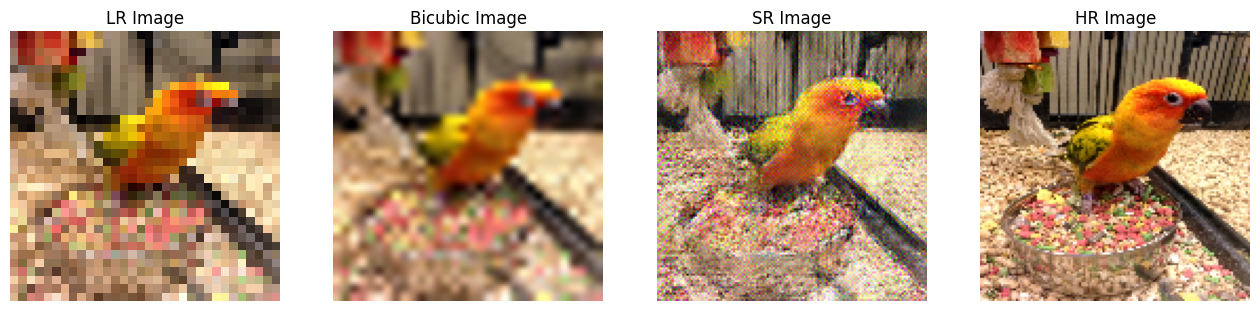

Content Loss for SR Image: 5.978306293487549


In [31]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

hr_path = "Test_Dataset/archive/hr_images/"
lr_path = "Test_Dataset/archive/lr_images/"

def load_image(filepath):
    img = Image.open(filepath).convert("RGB")
    transform = transforms.ToTensor()
    return transform(img)

hr_images = [os.path.join(hr_path, f) for f in os.listdir(hr_path)]
lr_images = [os.path.join(lr_path, f) for f in os.listdir(lr_path)]

ix = np.random.randint(0, len(lr_images))
lr_image = load_image(lr_images[ix]).unsqueeze(0).to(device)
hr_image = load_image(hr_images[ix]).unsqueeze(0).to(device)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Tải mô hình trên thiết bị phù hợp
generator.load_state_dict(torch.load("Test_Dataset/archive/final_generator.pt", map_location=device))
generator.to(device)
generator.eval()


with torch.no_grad():
    sr_image = generator(lr_image)

vgg_features_real = vgg(hr_image)
vgg_features_fake = vgg(sr_image)
content_loss = criterion_content(vgg_features_fake, vgg_features_real).item()  # Get the scalar value

bicubic_image = transforms.Resize((hr_image.shape[2], hr_image.shape[3]), Image.BICUBIC)(lr_image.squeeze(0).cpu())
bicubic_image = bicubic_image.unsqueeze(0).to(device)



lr_image = lr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
hr_image = hr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
sr_image = sr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
bicubic_image = bicubic_image.cpu().squeeze(0).permute(1, 2, 0).numpy()


plt.figure(figsize=(16, 6))

plt.subplot(1, 4, 1)
plt.title("LR Image")
plt.imshow(lr_image)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Bicubic Image")
plt.imshow(bicubic_image)
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("SR Image")
plt.imshow(sr_image)
plt.axis("off")


plt.subplot(1, 4, 4)
plt.title("HR Image")
plt.imshow(hr_image)
plt.axis("off")

plt.show()



print(f"Content Loss for SR Image: {content_loss}")